# Modeling and Generating Time-Series Data using TimeGAN


```ydata-synthetic``` repository contains material related with Generative Adversarial Networks for synthetic data generation, in particular regular tabular data and time-series. It consists a set of different GANs architectures developed using Tensorflow 2.0. Several example Jupyter Notebooks and Python scripts are included in the website, to show how to use the different architectures.

- [Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html) by Jinsung Yoon, Daniel Jarrett and Mihaela van der Schaar.

- [Reference](https://towardsdatascience.com/modeling-and-generating-time-series-data-using-timegan-29c00804f54d)

- [ydata-synthetic](https://pypi.org/project/ydata-synthetic/)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [41]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
'''
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K

import plotly
import plotly.express as px
'''

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.synthesizers import ModelParameters

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.4.1


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-06-28 09:57:51.161522: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-28 09:57:51.162272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:57:51.237589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 09:57:51.237878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2022-06-28 09:57:51.237896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:57:51.239373: I tensorflow/stream_executor/platform/def

### Energy dataset

The energy dataset (available [here](https://github.com/jsyoon0823/TimeGAN/blob/master/data/energy_data.csv) and originally taken from [here](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)), it actually looks like a regular tabular dataset only, with every row implying a new timestep and having its corresponding datapoints in the form of features. _Each of the entries is recorded after a duration of 10 minutes_.

In [5]:
data = pd.read_csv("energy_data.csv")

In [6]:
data.shape

(19735, 28)

In [7]:
data.dtypes

Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

In [8]:
data.isna().values.any()

False

In [9]:
data.isna().sum().sum()

0

In [10]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
# Use Min-max scaler-
# mm_scaler = MinMaxScaler(feature_range = (-1, 1))
# data_scaled = mm_scaler.fit_transform(data.values)

In [ ]:
# Sanity check-
# data_scaled.shape, data.shape

In [ ]:
# Convert to float-32 values-
# data_scaled = data_scaled.astype('float32')

In [ ]:
'''
# Sanity check-
for col in range(data_scaled.shape[1]):
    print(f"{col}; min = {data_scaled[:, col].min():.4f} &"
          f" max = {data_scaled[:, col].max():.4f}")
'''

### Convert 2-D time series into 3-D

- The 2-D time series is _expected_ to look like a 3-D tabular dataset. This is where we can make use of a clever way of sampling datapoints in order to create the 3rd dimension.

- We __take a window of size 24__ and run it along the rows of the dataset, shifting by one position at a time (sliding window protocol) and hence obtaining a certain number of 2D matrices, __each having a length of 24 and with all our coloumn features__.

- In the energy dataset, there are 19736 rows. By shift-sampling every 24 rows, we get 19712 entries, each having 24 rows and 28 features. We can then randomly mix them in order to make them Independent and Identically Distributed (IID). So, we get a dataset of dimensions (19712, (24, 28)), where each of the 19712 instances has 24 rows (aka timesteps) and 28 features.

In [19]:
def real_data_loading(data: np.array, seq_len):
    """
    Load and preprocess real-world datasets.
    Args:
      - data_name: Numpy array with the values from a a Dataset
      - seq_len: sequence length
    Returns:
      - data: preprocessed data.
      
    Method implemented here: https://github.com/jsyoon0823/TimeGAN/blob/master/data_loading.py
    Originally used in TimeGAN research
    """
    # Flip the data to make chronological data-
    ori_data = data[::-1]
    
    # Normalize the data-
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    # Preprocess the dataset-
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)-
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data


In [20]:
data_time_3d = real_data_loading(data = data, seq_len = 24)

In [23]:
type(data_time_3d), len(data_time_3d)

(list, 19711)

In [24]:
data_time_3d[1].shape, data_time_3d[2345].shape

((24, 28), (24, 28))

In [27]:
"""
try:
    energy_df = energy_df.set_index('Date').sort_index()
except:
    energy_df=energy_df
"""

# Data transformations to be applied prior to be used with the synthesizer model-
energy_data = real_data_loading(data.values, seq_len = 24)

In [28]:
print(len(energy_data), energy_data[0].shape)

19711 (24, 28)


In [31]:
type(energy_data), len(energy_data)

(list, 19711)

### Train TimeGAN

[Reference](https://github.com/ydataai/ydata-synthetic/blob/dev/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb)

In [37]:
# number of timesteps-
seq_len = 24

# number of features-
n_seq = 28

# number of hidden (LSTM/GRU) hidden units for generator-
hidden_dim = 24
# Also decides output_units for generator

# Used for discriminator loss- 
gamma = 1

# Used by generator as a starter dimension-
noise_dim = 32

# Not used-
dim = 128

batch_size = 128

learning_rate = 5e-4

# Not used-
beta_1 = 0
beta_2 = 1
data_dim = 28

In [42]:
# Define TimeGAN arguments-
gan_args = ModelParameters(
    batch_size = batch_size, lr = learning_rate,
    noise_dim = noise_dim, layers_dim = dim
)

In [43]:
# Initialize TimeGAN-
model_timeGAN = TimeGAN(
    model_parameters = gan_args, hidden_dim = hidden_dim,
    seq_len = seq_len, n_seq = n_seq,
    gamma = 1
)

In [44]:
# Train model-
model_timeGAN.train(data = energy_data, train_steps = 500)

2022-06-28 10:15:05.970519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 10:15:05.972554: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-28 10:15:05.972784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 10:15:05.973064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88Gi

InternalError:  Failed to load in-memory CUBIN: CUDA_ERROR_NO_BINARY_FOR_GPU: no kernel image is available for execution on the device
	 [[node Abs (defined at home/arjun/anaconda3/envs/TimeGAN/lib/python3.8/site-packages/ydata_synthetic/synthesizers/timeseries/timegan/model.py:172) ]] [Op:__inference_train_generator_91979]

Function call stack:
train_generator


In [ ]:
# Save trained model-
model_timeGAN.save("Trained_TimeGAN_energy.pkl")

In [45]:
# Generate synthetic data-
synth_data = model_timeGAN.sample(len(energy_data))

Synthetic data generation: 100%|███████████████████████████████████| 154/154 [00:06<00:00, 23.60it/s]


In [48]:
synth_data.shape, len(energy_data)

((19712, 24, 28), 19711)

In [50]:
np.vstack(energy_data).shape, np.vstack(synth_data).shape

((473064, 28), (473088, 28))

In [51]:
energy_data_s = np.vstack(energy_data)
synth_data_s = np.vstack(synth_data)

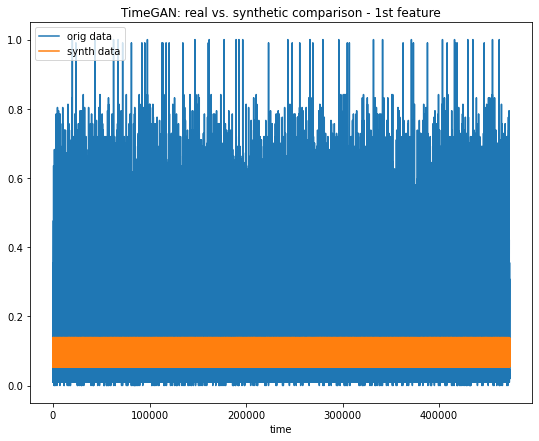

In [52]:
plt.figure(figsize = (9, 7))
plt.plot(energy_data_s[:, 0], label = "orig data")
plt.plot(synth_data_s[:, 0], label = 'synth data')
plt.xlabel("time")
plt.title("TimeGAN: real vs. synthetic comparison - 1st feature")
plt.legend(loc = 'best')
plt.show()

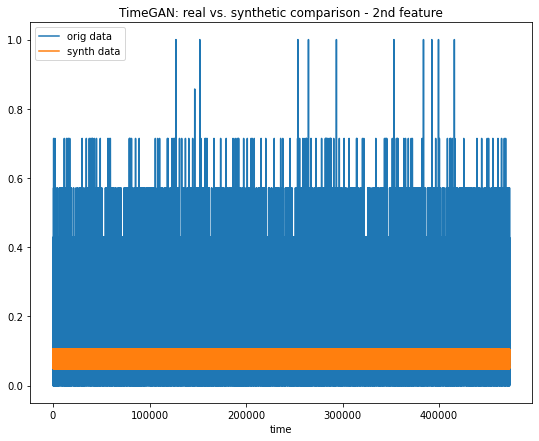

In [53]:
plt.figure(figsize = (9, 7))
plt.plot(energy_data_s[:, 1], label = "orig data")
plt.plot(synth_data_s[:, 1], label = 'synth data')
plt.xlabel("time")
plt.title("TimeGAN: real vs. synthetic comparison - 2nd feature")
plt.legend(loc = 'best')
plt.show()